In [1]:
from notepad import WaterStorage, Heatpump
from pyrecoy.forecasts import Mipf
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import cufflinks
cufflinks.go_offline()
from numpy.polynomial import Polynomial
import numpy as np

In [3]:
import plotly.express as px
from pyrecoy.colors import *

In [4]:
mipf = Mipf(
    start = '2018-11-01',
    end = '2018-12-01', 
    tidy=True, 
    include_nextQ=False,
    folder_path=r"C:\Users\Shahla Huseynova\Recoy\Recoy - Documents\03 - Libraries\12 - Data Management\Forecast Data"
).data
# mipf.columns
price_data = mipf[['DAM', 'POS', 'NEG', 'ForeNeg', 'ForePos']]
# price_data.index = price_data.index.tz_convert('Europe/Amsterdam')
price_data = price_data.resample('15T').mean()
price_data

DAM    POS    NEG    ForeNeg    ForePos
datetime                                                            
2018-11-01 00:00:00+01:00  44.90  46.39  46.39  53.603333  44.623333
2018-11-01 00:15:00+01:00  44.90  43.08  43.08  68.962000  63.177333
2018-11-01 00:30:00+01:00  44.90  43.13  43.13  55.415333  57.922667
2018-11-01 00:45:00+01:00  44.90  46.29  46.29  57.633333  54.712667
2018-11-01 01:00:00+01:00  42.46  32.03  32.03  37.354000  35.400000
...                          ...    ...    ...        ...        ...
2018-12-01 22:45:00+01:00  45.99  35.97  35.97  33.540667  33.544667
2018-12-01 23:00:00+01:00  45.40  35.97  54.71  55.733333  44.383333
2018-12-01 23:15:00+01:00  45.40  49.63  49.63  52.096667  52.830000
2018-12-01 23:30:00+01:00  45.40  43.75  51.42  47.120667  45.217333
2018-12-01 23:45:00+01:00  45.40  35.97  35.97  33.191333  33.362000

[2976 rows x 5 columns]

In [5]:
data = pd.read_excel('Demand_Data_Smurfit_Preprocessed.xlsx', sheet_name='nov2018', index_col=0)
start, end = '2018-11-01 00:00:00', '2018-12-01 00:00:00'
# start, end = '2018-11-01 00:00:00', '2018-12-01 00:00:00'
df = data[start:end]
df.index = df.index.tz_localize('Europe/Amsterdam')
df = df.resample('15T').mean()
df=df.drop(['Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12'], axis=1)

df.head()

Tsource (VDG)  Tsink (VDG)  MW (VDG)  \
2018-11-01 00:00:00+01:00      64.964783   142.003109       0.0   
2018-11-01 00:15:00+01:00      54.578777   138.960493       0.0   
2018-11-01 00:30:00+01:00      65.166672   139.885329       0.0   
2018-11-01 00:45:00+01:00      65.358078   139.731901       0.0   
2018-11-01 01:00:00+01:00      64.947536   139.577871       0.0   

                           Tsource (NDG)  Tsink (NDG)  MW (NDG)  
2018-11-01 00:00:00+01:00      19.897433   147.731814       0.0  
2018-11-01 00:15:00+01:00      17.950905   148.138964       0.0  
2018-11-01 00:30:00+01:00      33.500757   147.585426       0.0  
2018-11-01 00:45:00+01:00      42.203876   147.547612       0.0  
2018-11-01 01:00:00+01:00      18.702675   148.260335       0.0

In [6]:
waterstorage = WaterStorage(
    name='MyStorage',
    max_power=10,
    min_power=-10,
    roundtrip_eff=0.90,
    capacity_per_volume = 50 * 1e-3,
    volume = 1000,
    lifetime = 25,
    temperature = 368, #K
    min_storagelevel = 5,
    # max_storagelevel = 50
    
)
waterstorage.set_freq('15T')
waterstorage.set_storagelevel(15)
waterstorage.storagelevel

15

In [7]:
Tsink = 140  #Celcius
Tsource = 60
Tref = 0
hp_capacity = 31 #MW
process_demand_MW = 25 #MW
Cp = 4190  #J/kgK
MWtoJs = 1000_000
efficiency = 0.9
Tstorage = 95

print('process demand', process_demand_MW)
# hp_capacity vs hp_load?

process demand 25


In [8]:
waterstorage.max_storage_capacity

50.0

In [9]:
print('process_demand_MW', process_demand_MW)
print('hp_capacity', hp_capacity)

process_demand_MW 25
hp_capacity 31


In [10]:
def hp_mass_flow (hp_capacity, Tsink, Tref, Cp):
    return hp_capacity * MWtoJs /(Cp*(Tsink - Tref)) #kg/s

def process_mass_flow (process_demand_MW, Tsink, Tref, Cp):
    return process_demand_MW * MWtoJs /(Cp*(Tsink - Tref)) 

def cop_curve(Tsink, Tsource):
    c0 = Tsink / (Tsink - Tsource)  
    return Polynomial([c0])

# charge_mass_flow = hp_mass_flow (hp_capacity, Tsink, Tref, Cp) - process_mass_flow (process_demand_MW, Tsink, Tref, Cp)  #kg/s

# def energy_to_storage (charge_mass_flow, Cp, Tsink, Tref):
#     return (charge_mass_flow * Cp * (Tsink - Tref)) / MWtoJs

def energy_to_storage(hp_capacity, process_demand_MW):
    return hp_capacity - process_demand_MW  #MW


# discharged_heat = energy_to_storage(hp_capacity, process_demand_MW) #MW

# def charged_heat (charge_mass_flow, Cp, Tsink, Tref):
#     return (charge_mass_flow * Cp * (Tsink - Tref)) / MW_to_J_per_s

# discharged_heat = charged_heat(charge_mass_flow, Cp, Tsink, Tref)  #MW

def discharge_mass_flow (discharged_heat, Cp, Tstorage, Tref):
    return discharged_heat*MWtoJs/(Cp*(Tstorage - Tref))

def Tsource_calculation(Tstorage, discharge_mass_flow, Tsource, process_mass_flow):
    return ((Tstorage * discharge_mass_flow + Tsource * process_mass_flow)
 / (discharge_mass_flow + process_mass_flow))


# charged_heat can be also defined as hp_capacity-process_demand_MW

In [11]:
energy_to_storage(hp_capacity, process_demand_MW)

6

In [12]:
# heatpump = Heatpump("heatpump1", 50, cop_curve, 10)
# heatpump.set_heat_output(50, Tsource=333, Tsink=413)
cop_curve(140, 60)

heatpump = Heatpump(
    name='Heatpump',
    max_th_power=40,
    min_th_power=5,
    cop_curve=cop_curve
)

heatpump.__dict__



{'name': 'Heatpump',
 'max_th_power': 40,
 'min_th_power': 5,
 'cop_curve': <function __main__.cop_curve(Tsink, Tsource)>}

In [13]:
# heatpump.get_cop(50, Tsource=333, Tsink=413)


In [14]:
heatpump.set_heat_output(20, Tsource=333, Tsink=41+372)


(-3.8740920096852305, 20)

In [15]:
for col in price_data.columns:
    df[col] = price_data[col]
df.head(10)
# iki dataframeni birlesdirdik burda

Tsource (VDG)  Tsink (VDG)   MW (VDG)  \
2018-11-01 00:00:00+01:00      64.964783   142.003109   0.000000   
2018-11-01 00:15:00+01:00      54.578777   138.960493   0.000000   
2018-11-01 00:30:00+01:00      65.166672   139.885329   0.000000   
2018-11-01 00:45:00+01:00      65.358078   139.731901   0.000000   
2018-11-01 01:00:00+01:00      64.947536   139.577871   0.000000   
2018-11-01 01:15:00+01:00      65.073433   139.423357   0.000000   
2018-11-01 01:30:00+01:00      47.711559   140.328730   0.000000   
2018-11-01 01:45:00+01:00      29.525829   140.298902   0.000000   
2018-11-01 02:00:00+01:00      65.715569   139.991650  10.139587   
2018-11-01 02:15:00+01:00      65.929909   148.342325  19.585104   

                           Tsource (NDG)  Tsink (NDG)  MW (NDG)    DAM    POS  \
2018-11-01 00:00:00+01:00      19.897433   147.731814  0.000000  44.90  46.39   
2018-11-01 00:15:00+01:00      17.950905   148.138964  0.000000  44.90  43.08   
2018-11-01 00:30:00+01:00      33.500757   147.585426  0.000000  44.90  43.13   
2018-11-01 00:45:00+01:00      42.203876   147.547612  0.000000  44.90  46.29   
2018-11-01 01:00:00+01:00      18.702675   148.260335  0.000000  42.46  32.03   
2018-11-01 01:15:00+01:00      19.903652   149.186865  0.000000  42.46  32.03   
2018-11-01 01:30:00+01:00      19.574467   147.800016  0.000000  42.46  34.48   
2018-11-01 01:45:00+01:00      17.065464   147.906886  0.000000  42.46  32.07   
2018-11-01 02:00:00+01:00      49.339708   149.603741  3.333301  44.00  40.66   
2018-11-01 02:15:00+01:00      61.721718   155.887905  6.455359  44.00  46.04   

                             NEG    ForeNeg    ForePos  
2018-11-01 00:00:00+01:00  46.39  53.603333  44.623333  
2018-11-01 00:15:00+01:00  43.08  68.962000  63.177333  
2018-11-01 00:30:00+01:00  43.13  55.415333  57.922667  
2018-11-01 00:45:00+01:00  46.29  57.633333  54.712667  
2018-11-01 01:00:00+01:00  32.03  37.354000  35.400000  
2018-11-01 01:15:00+01:00  32.03  35.934000  31.469333  
2018-11-01 01:30:00+01:00  34.48  37.640000  35.276000  
2018-11-01 01:45:00+01:00  32.07  31.026667  28.963333  
2018-11-01 02:00:00+01:00  40.66  40.547333  38.702000  
2018-11-01 02:15:00+01:00  46.04  44.696000  42.961333

In [16]:
for i in df.index:
    df.loc[i, 'hp_mass'] = hp_mass_flow(hp_capacity, df.loc[i, 'Tsink (VDG)'], Tref, Cp)
    df.loc[i, 'process_mass'] = process_mass_flow(df.loc[i, 'MW (VDG)'], df.loc[i, 'Tsink (VDG)'],Tref, Cp)
    df.loc[i, 'COP'] = cop_curve(df.loc[i, 'Tsink (VDG)']+273, df.loc[i, 'Tsource (VDG)']+273)
    df.loc[i, 'charge_mass'] = df.loc[i, 'hp_mass'] - df.loc[i, 'process_mass']
    
df.head()

Tsource (VDG)  Tsink (VDG)  MW (VDG)  \
2018-11-01 00:00:00+01:00      64.964783   142.003109       0.0   
2018-11-01 00:15:00+01:00      54.578777   138.960493       0.0   
2018-11-01 00:30:00+01:00      65.166672   139.885329       0.0   
2018-11-01 00:45:00+01:00      65.358078   139.731901       0.0   
2018-11-01 01:00:00+01:00      64.947536   139.577871       0.0   

                           Tsource (NDG)  Tsink (NDG)  MW (NDG)    DAM    POS  \
2018-11-01 00:00:00+01:00      19.897433   147.731814       0.0  44.90  46.39   
2018-11-01 00:15:00+01:00      17.950905   148.138964       0.0  44.90  43.08   
2018-11-01 00:30:00+01:00      33.500757   147.585426       0.0  44.90  43.13   
2018-11-01 00:45:00+01:00      42.203876   147.547612       0.0  44.90  46.29   
2018-11-01 01:00:00+01:00      18.702675   148.260335       0.0  42.46  32.03   

                             NEG    ForeNeg    ForePos    hp_mass  \
2018-11-01 00:00:00+01:00  46.39  53.603333  44.623333  52.101451   
2018-11-01 00:15:00+01:00  43.08  68.962000  63.177333  53.242241   
2018-11-01 00:30:00+01:00  43.13  55.415333  57.922667  52.890236   
2018-11-01 00:45:00+01:00  46.29  57.633333  54.712667  52.948310   
2018-11-01 01:00:00+01:00  32.03  37.354000  35.400000  53.006741   

                           process_mass                   COP  charge_mass  
2018-11-01 00:00:00+01:00           0.0   (5.386969459992516)    52.101451  
2018-11-01 00:15:00+01:00           0.0   (4.882106135030027)    53.242241  
2018-11-01 00:30:00+01:00           0.0  (5.5258665771869335)    52.890236  
2018-11-01 00:45:00+01:00           0.0   (5.549424302045392)    52.948310  
2018-11-01 01:00:00+01:00           0.0   (5.528286493353138)    53.006741

In [17]:
# df.index = df.index.tz_localize('Europe/Amsterdam')
for i in df.index:
    df.loc[i, 'process_mass'] = process_mass_flow(df.loc[i, 'MW (VDG)'], df.loc[i, 'Tsink (VDG)'],Tref, Cp)
    hp_load = df.loc[i, 'MW (VDG)']
    old_COP = heatpump.get_cop(hp_load, df.loc[i,'Tsink (VDG)']+273, df.loc[i, 'Tsource (VDG)']+273)
    df.loc[i,'hp_consumption_old'] = hp_load/ old_COP
        
    if df.loc[i, 'ForeNeg'] < df['DAM'].mean() - 10:
        hp_load = heatpump.max_th_power
        energy_2_storage = hp_load - df.loc[i, 'MW (VDG)']
        waterstorage.charge(energy_2_storage)
        df.loc[i, 'charged_heat'] = waterstorage.charge(energy_2_storage)
        charge_mass = hp_mass_flow (hp_capacity,  df.loc[i, 'Tsink (VDG)']+273, Tref+273, Cp) - process_mass_flow (df.loc[i, 'MW (VDG)'], df.loc[i, 'Tsink (VDG)']+273, Tref+273, Cp)
        df.loc[i, 'new_cl'] = waterstorage.storagelevel
        new_COP = heatpump.get_cop(hp_load, df.loc[i,'Tsink (VDG)']+273, df.loc[i, 'Tsource (VDG)']+273)
        df.loc[i,'hp_consumption_new'] =  hp_load/ new_COP
    elif price_data.loc[i,'ForePos'] > df['DAM'].mean() + 10:
        energy_from_storage = energy_to_storage(hp_capacity ,df.loc[i, 'MW (VDG)'])
        waterstorage.discharge(energy_from_storage)
        df.loc[i, 'discharged_heat'] =   waterstorage.discharge(energy_from_storage)
        df.loc[i, 'new_cl'] = waterstorage.storagelevel
        discharge_mass = discharge_mass_flow(df.loc[i, 'discharged_heat'], Cp, Tstorage, Tref)
        df.loc[i, 'discharge_mass'] = discharge_mass
        process_mass = process_mass_flow (df.loc[i, 'MW (VDG)'], df.loc[i, 'Tsink (VDG)']+273, Tref+273, Cp)
        df.loc[i, 'Tsource_new'] = Tsource_calculation(Tstorage, df.loc[i, 'discharge_mass'], df.loc[i, 'Tsource (VDG)'], process_mass)
        heat_output = heatpump.set_heat_output(df.loc[i, 'MW (VDG)'], df.loc[i,'Tsink (VDG)']+273, df.loc[i, 'Tsource_new']+273)
        df.loc[i,'hp_consumption_new'] = heat_output[0]
        df.loc[i, 'new_COP'] = heatpump.get_cop(heat_output[1], df.loc[i,'Tsink (VDG)']+273, df.loc[i, 'Tsource_new']+273)
    else:
        hp_load = df.loc[i, 'MW (VDG)']
        df.loc[i, 'old_COP'] = old_COP
        df.loc[i,'hp_consumption_old'] =  hp_load/ old_COP
        df.loc[i, 'new_cl'] = 0
        df.loc[i,'hp_consumption_new'] = 0

C:\Users\Shahla Huseynova\python\Encore\Simulations\notepad.py:319: UserWarning:

Chosen heat output is out of range [5 - 40]. Heat output is being limited to the closest boundary.

C:\Users\SHAHLA~1\AppData\Local\Temp/ipykernel_7928/3971255130.py:31: RuntimeWarning:

invalid value encountered in double_scalars



In [18]:
df[['ForeNeg', 'ForePos','discharged_heat', 'Tsource_new']]

ForeNeg    ForePos  discharged_heat  Tsource_new
2018-11-01 00:00:00+01:00  53.603333  44.623333              NaN          NaN
2018-11-01 00:15:00+01:00  68.962000  63.177333              NaN          NaN
2018-11-01 00:30:00+01:00  55.415333  57.922667              NaN          NaN
2018-11-01 00:45:00+01:00  57.633333  54.712667              NaN          NaN
2018-11-01 01:00:00+01:00  37.354000  35.400000              NaN          NaN
...                              ...        ...              ...          ...
2018-11-30 23:00:00+01:00  65.636000  60.364667              NaN          NaN
2018-11-30 23:15:00+01:00  54.434667  51.784667              NaN          NaN
2018-11-30 23:30:00+01:00  45.918000  44.090000              NaN          NaN
2018-11-30 23:45:00+01:00  46.302667  42.924667              NaN          NaN
2018-12-01 00:00:00+01:00  84.520000  71.147333              NaN          NaN

[2881 rows x 4 columns]

In [19]:
df['new_cl']

2018-11-01 00:00:00+01:00     0.0
2018-11-01 00:15:00+01:00     0.0
2018-11-01 00:30:00+01:00     0.0
2018-11-01 00:45:00+01:00     0.0
2018-11-01 01:00:00+01:00    35.0
                             ... 
2018-11-30 23:00:00+01:00     0.0
2018-11-30 23:15:00+01:00     0.0
2018-11-30 23:30:00+01:00    47.5
2018-11-30 23:45:00+01:00    47.5
2018-12-01 00:00:00+01:00     0.0
Freq: 15T, Name: new_cl, Length: 2881, dtype: float64

In [20]:
df.loc['2018-11-01 18:00:00+01:00', 'new_cl']

42.351294253690725

In [21]:
time_factor = 1/4

for col in price_data.columns:
    df[col] = price_data[col]
for cons in ['old', 'new']:
    df['nomination_MWh'] = df['MW (VDG)'] * time_factor
    df[f'imbalance_MWh_{cons}'] = df['nomination_MWh'] - (df[f'hp_consumption_{cons}']*time_factor)
    df['day-ahead costs'] = df['nomination_MWh'] * df['DAM'] 

    is_pos = df[f'imbalance_MWh_{cons}'] > 0
    df.loc[is_pos, f'imbalance costs_{cons}'] = df.loc[is_pos, f'imbalance_MWh_{cons}'] * df['POS'] 

    is_neg = df[f'imbalance_MWh_{cons}'] < 0
    df.loc[is_neg, f'imbalance costs_{cons}'] = -df.loc[is_neg, f'imbalance_MWh_{cons}'] * df['NEG'] 

    df[f'total cost_{cons}'] = df['day-ahead costs'] + df[f'imbalance costs_{cons}']

In [22]:
df['new_COP']

2018-11-01 00:00:00+01:00   NaN
2018-11-01 00:15:00+01:00   NaN
2018-11-01 00:30:00+01:00   NaN
2018-11-01 00:45:00+01:00   NaN
2018-11-01 01:00:00+01:00   NaN
                             ..
2018-11-30 23:00:00+01:00   NaN
2018-11-30 23:15:00+01:00   NaN
2018-11-30 23:30:00+01:00   NaN
2018-11-30 23:45:00+01:00   NaN
2018-12-01 00:00:00+01:00   NaN
Freq: 15T, Name: new_COP, Length: 2881, dtype: float64

In [23]:
df['DAM'].mean()

62.27883373828532

In [24]:
df['NEG'].mean()

69.33902464422076

In [25]:
df['ForePos']

2018-11-01 00:00:00+01:00    44.623333
2018-11-01 00:15:00+01:00    63.177333
2018-11-01 00:30:00+01:00    57.922667
2018-11-01 00:45:00+01:00    54.712667
2018-11-01 01:00:00+01:00    35.400000
                               ...    
2018-11-30 23:00:00+01:00    60.364667
2018-11-30 23:15:00+01:00    51.784667
2018-11-30 23:30:00+01:00    44.090000
2018-11-30 23:45:00+01:00    42.924667
2018-12-01 00:00:00+01:00    71.147333
Freq: 15T, Name: ForePos, Length: 2881, dtype: float64

#### VISUALIZATION

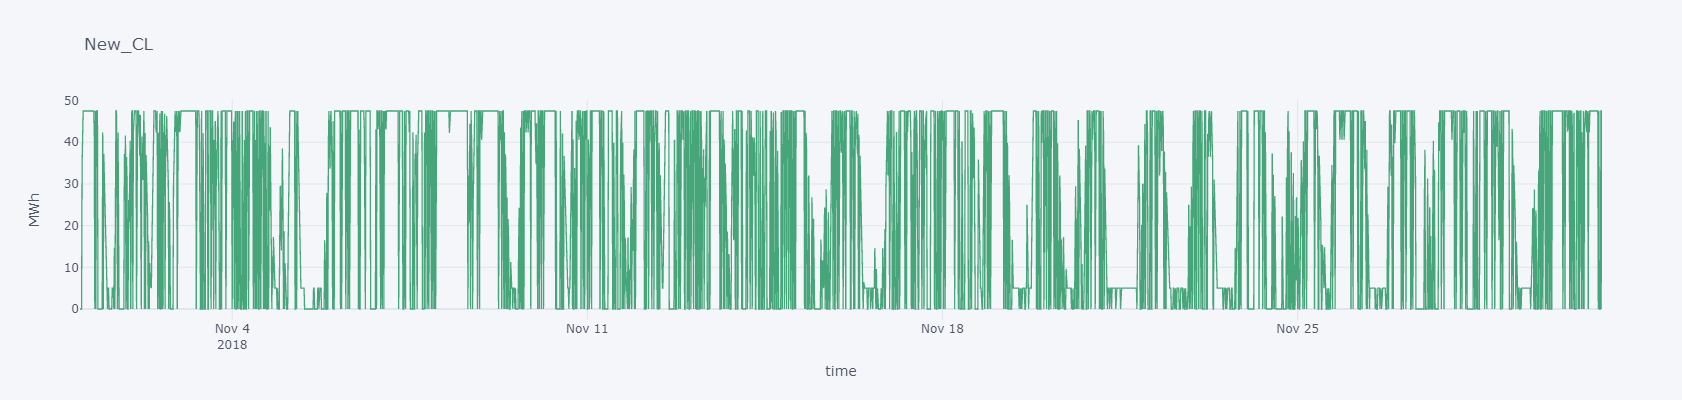

In [26]:
fig_storage_level_over_time = df['new_cl'].iplot(
    title='New_CL',
    xTitle='time',
    yTitle='MWh', 
    colors=recoygreen,
    asFigure=True,
    dimensions=(1000, 400)
)
fig_storage_level_over_time

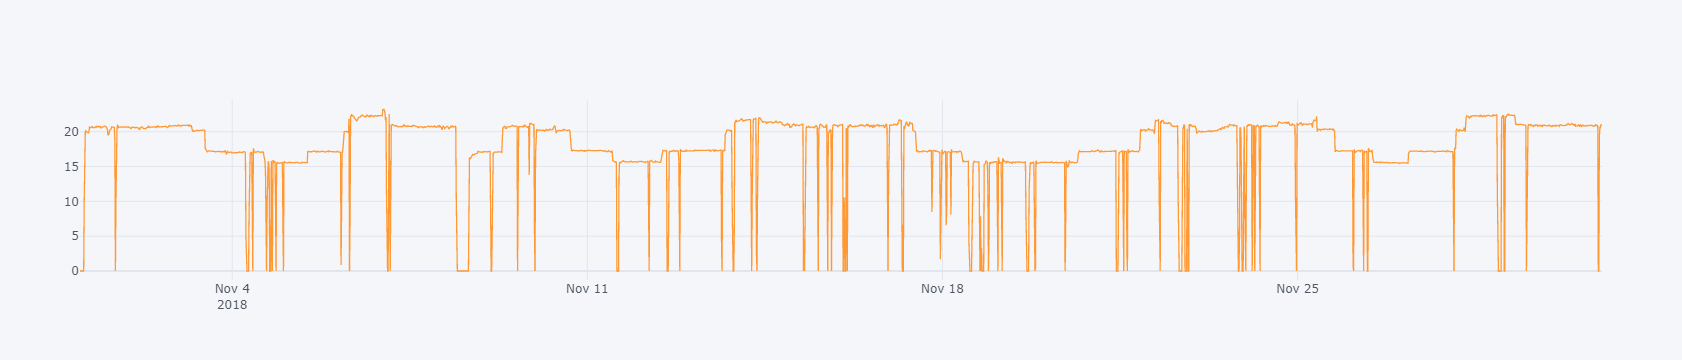

In [27]:
df['MW (VDG)'].iplot()

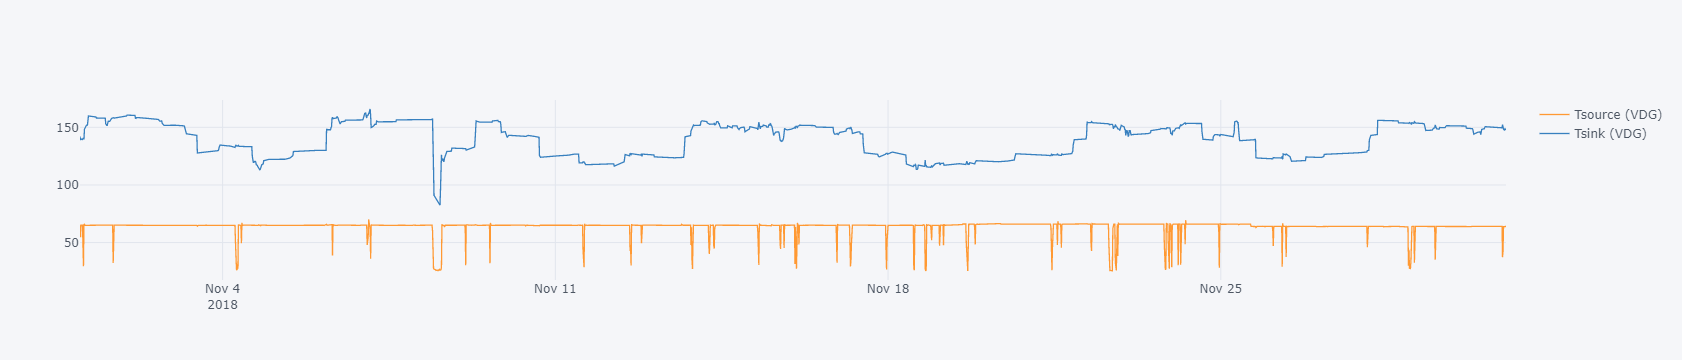

In [28]:
df[['Tsource (VDG)', 'Tsink (VDG)']].iplot()

In [29]:
df['Tsource (VDG)'].mean()

63.66131929339985

In [30]:
# Imbalance_price = df[['NEG', 'DAM'].iplot(
#     subplots=True, 
#     title='Market price',
#     subplot_titles=['Imbalance price(€/MWh)', 'Electricity price(€/MWh)'],
#     legend=False,
#     dimensions=(800, 600),
#     colors=[recoydarkblue, recoygreen],
#     asFigure=True
# )
# Imbalance_price

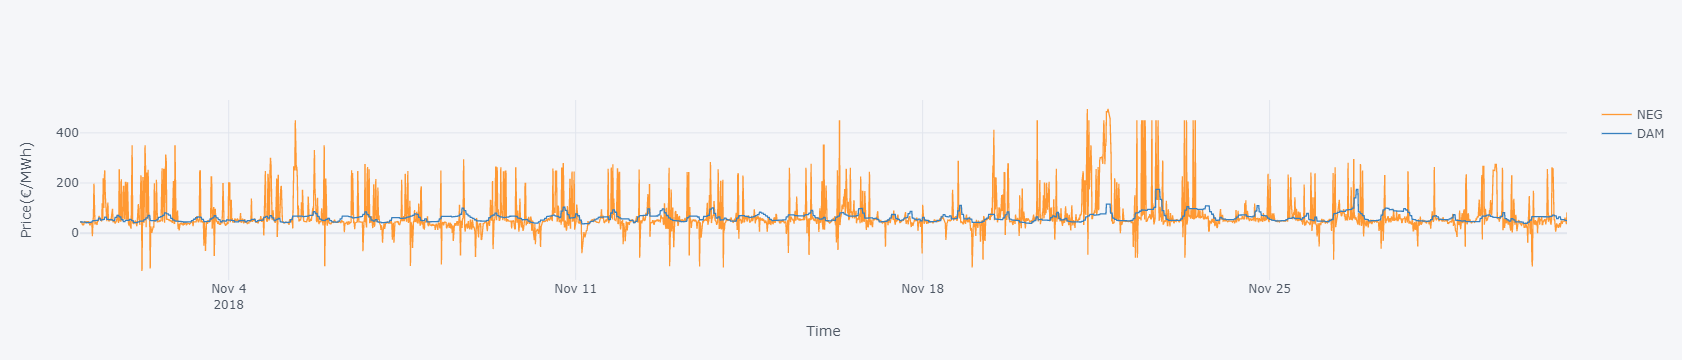

In [31]:
df[['NEG', 'DAM']].iplot(kind = 'line', xTitle='Time', yTitle='Price(€/MWh)')

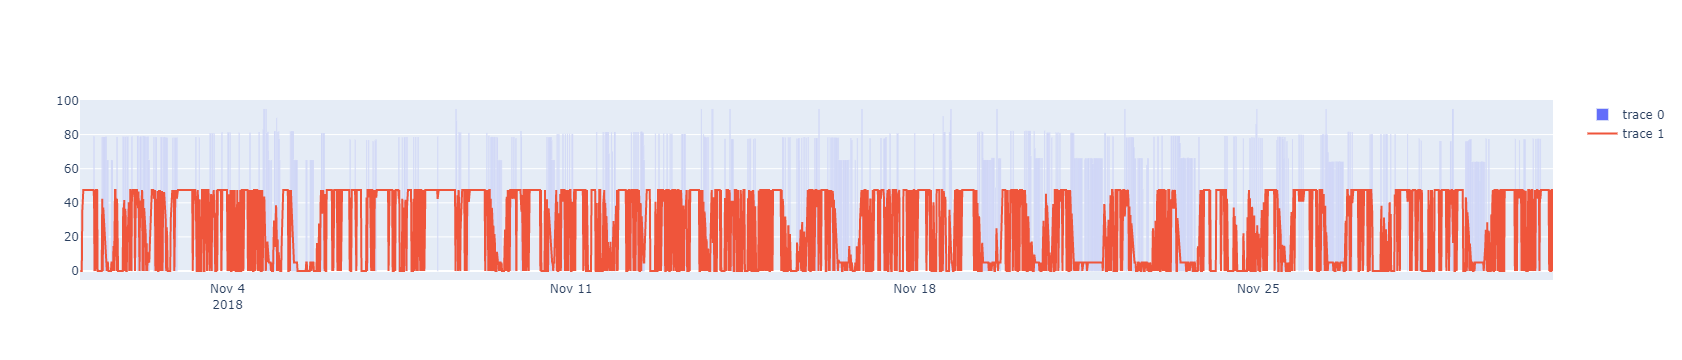

In [32]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Bar(
    x=df.index,
    y=df['Tsource_new'],

    # xperiodalignment="middle",
    # xhoverformat="Q%q",
    # hovertemplate="%{y}%{_xother}"
))

fig.add_trace(go.Scatter(
    x=df.index,
    y=df['new_cl'],
    # xperiodalignment="middle",
    # hovertemplate="%{y}%{_xother}"
))

fig.update_layout(hovermode="x unified")
fig.show()

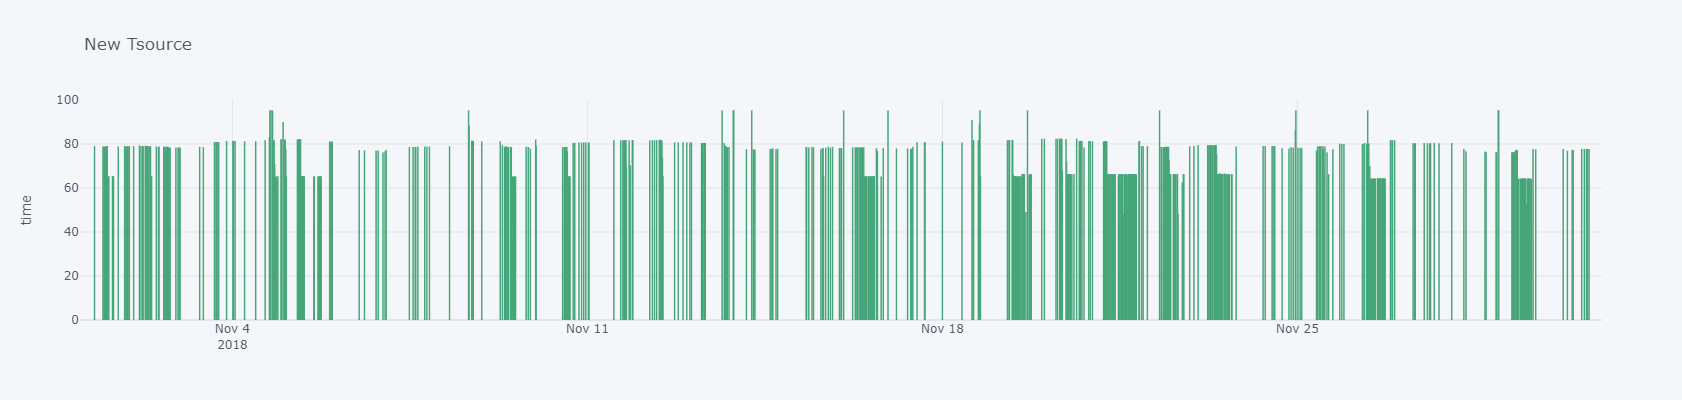

In [33]:
Tsource_new = df['Tsource_new']
Tsource_new= Tsource_new.iplot(
    kind='bar',
    title='New Tsource',
    colors=recoygreen,
    dimensions=(600, 400),
    yTitle='time'
)
Tsource_new

In [34]:
df['total cost_old']

2018-11-01 00:00:00+01:00           NaN
2018-11-01 00:15:00+01:00           NaN
2018-11-01 00:30:00+01:00           NaN
2018-11-01 00:45:00+01:00           NaN
2018-11-01 01:00:00+01:00           NaN
                                ...    
2018-11-30 23:00:00+01:00    522.238190
2018-11-30 23:15:00+01:00    464.281378
2018-11-30 23:30:00+01:00    454.325279
2018-11-30 23:45:00+01:00    419.609743
2018-12-01 00:00:00+01:00    609.487824
Freq: 15T, Name: total cost_old, Length: 2881, dtype: float64

In [35]:
print(df['total cost_new'].sum())
print(df['total cost_old'].sum())

1611566.3265981267
1463381.24579542


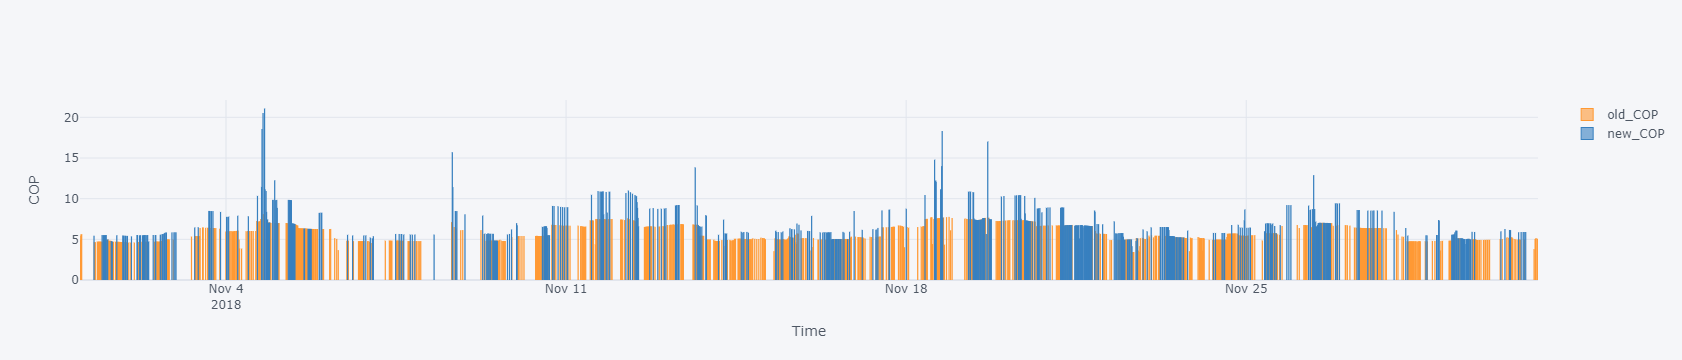

In [36]:
df[['old_COP', 'new_COP']].iplot(kind = 'bar', xTitle='Time', yTitle='COP')

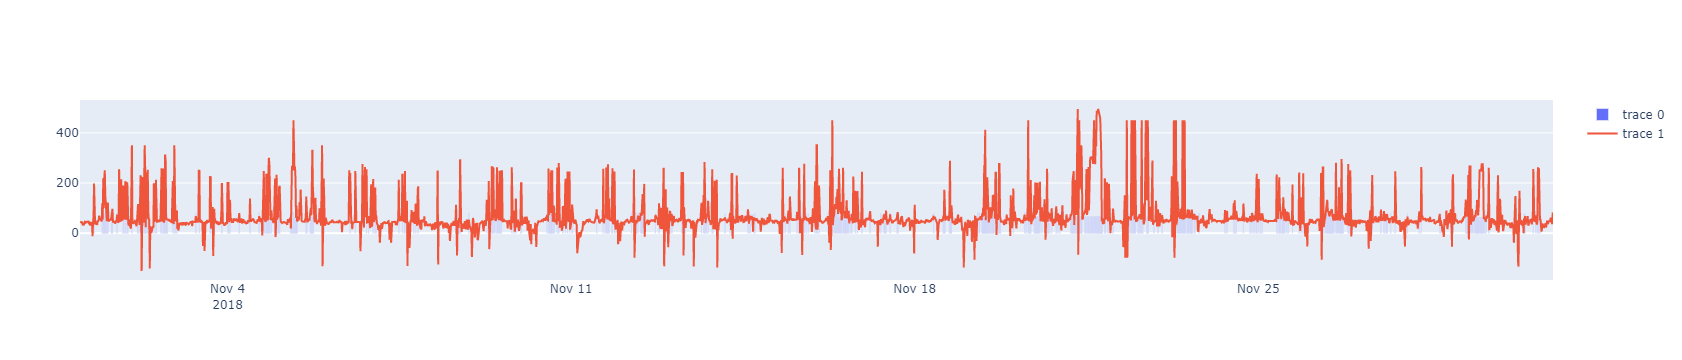

In [37]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Bar(
    x=df.index,
    y=df['Tsource_new'],

    # xperiodalignment="middle",
    # xhoverformat="Q%q",
    # hovertemplate="%{y}%{_xother}"
))

fig.add_trace(go.Scatter(
    x=df.index,
    y=df['NEG'],
    # xperiodalignment="middle",
    # hovertemplate="%{y}%{_xother}"
))

fig.update_layout(hovermode="x unified")
fig.show()

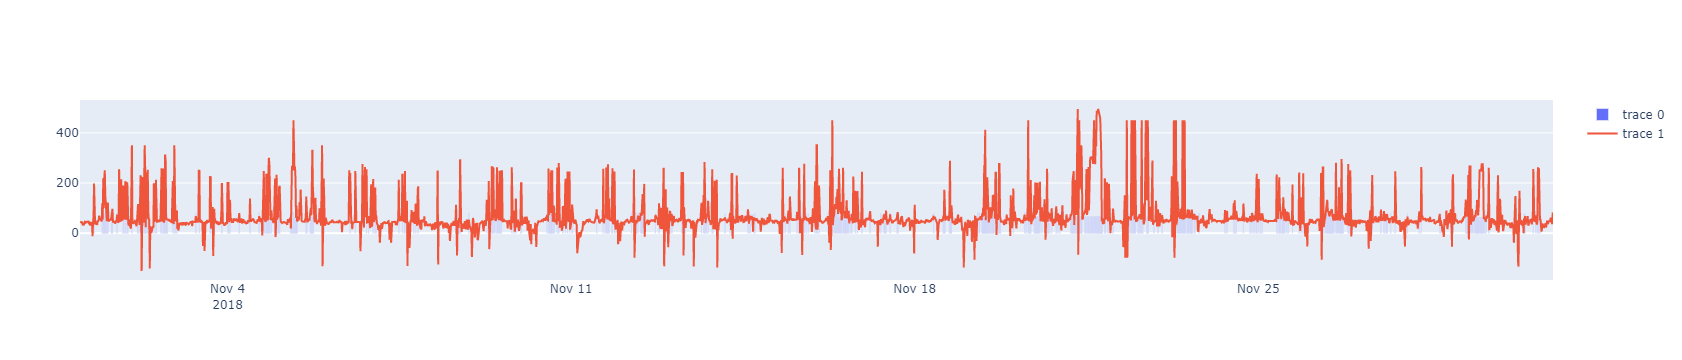

In [38]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Bar(
    x=df.index,
    y=df['Tsource_new'],

    # xperiodalignment="middle",
    # xhoverformat="Q%q",
    # hovertemplate="%{y}%{_xother}"
))

fig.add_trace(go.Scatter(
    x=df.index,
    y=df['NEG'],
    # xperiodalignment="middle",
    # hovertemplate="%{y}%{_xother}"
))

fig.update_layout(hovermode="x unified")
fig.show()

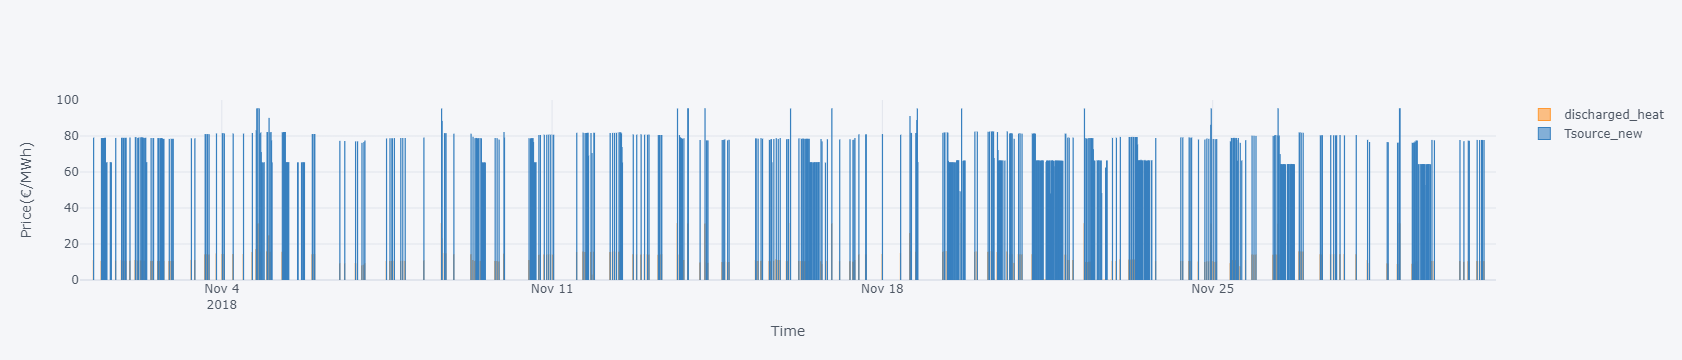

In [39]:
df[['discharged_heat', 'Tsource_new']].iplot(kind = 'bar', xTitle='Time', yTitle='Price(€/MWh)')

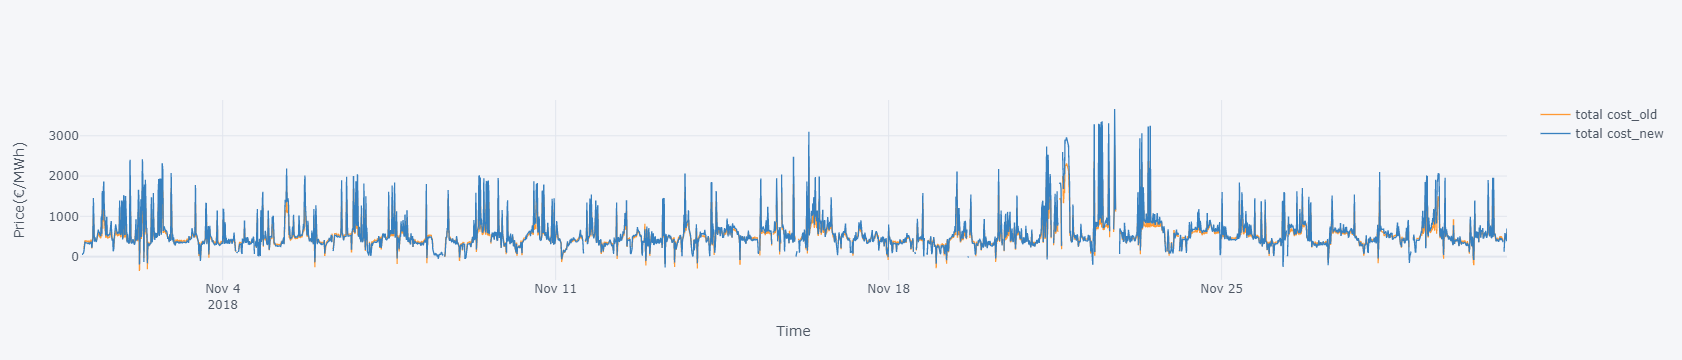

In [40]:
df[['total cost_old', 'total cost_new']].iplot(kind = 'line', xTitle='Time', yTitle='Price(€/MWh)')